In [1]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import hvplot.xarray
import os
import geoviews as gv
import panel as pn
pn.extension()
gv.extension('bokeh')

In [2]:
ds_raw = xr.load_dataset('../data/RG_ArgoClim_Salinity_2019.nc.gz', decode_times = False)
ds_raw

<xarray.Dataset> Size: 2GB
Dimensions:                (LONGITUDE: 360, LATITUDE: 145, PRESSURE: 58,
                            TIME: 180)
Coordinates:
  * LONGITUDE              (LONGITUDE) float32 1kB 20.5 21.5 ... 378.5 379.5
  * LATITUDE               (LATITUDE) float32 580B -64.5 -63.5 ... 78.5 79.5
  * PRESSURE               (PRESSURE) float32 232B 2.5 10.0 ... 1.975e+03
  * TIME                   (TIME) float32 720B 0.5 1.5 2.5 ... 177.5 178.5 179.5
Data variables:
    ARGO_SALINITY_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 12MB 34.07...
    ARGO_SALINITY_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 2GB ...
    BATHYMETRY_MASK        (PRESSURE, LATITUDE, LONGITUDE) float32 12MB 1.0 ....
    MAPPING_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 12MB 2e+03...

In [3]:
# Create a variable with the date of our first data point (origin)
t0 = np.datetime64("2004-01")
# Create a sequence representing the number 
# of months since 2004-01 ranging from 0 to 179
months = range(len(ds_raw.TIME))
# Create and array of dates where you add 1...179 months 
# to the origin date t0
time = np.array([t0 + np.timedelta64(m, "M") for m in months])

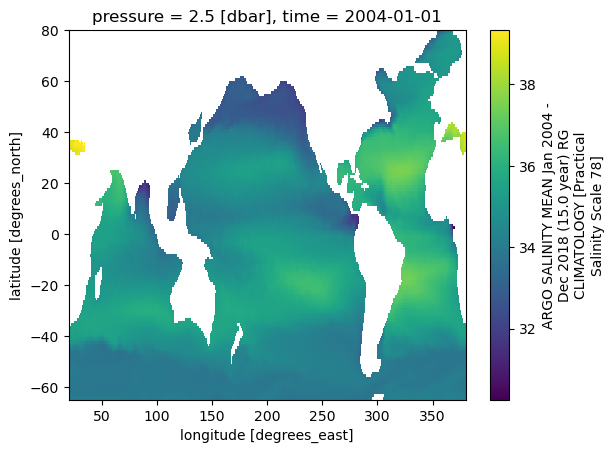

In [4]:
ds = ds_raw.rename({
    'TIME': 'time',
    'ARGO_SALINITY_MEAN': 'salinity_mean',
    'ARGO_SALINITY_ANOMALY': 'salinity_anom',
    'PRESSURE': 'pressure',
    'LATITUDE': 'latitude',
    'LONGITUDE': 'longitude'
})

# Assign corrected datetime array if needed
ds = ds.assign_coords(time=time)  # <- assuming `time` is a datetime64 array you've already created

# Plot surface salinity at first time point
ds.isel(time=0, pressure=0).salinity_mean.plot()

In [5]:
# You already did this correctly earlier
ds['longitude'] = ds['longitude'] % 360

greenland_box = ds.where(
    (ds.latitude >= 40) & (ds.latitude <= 83) &
    (ds.longitude >= 287) & (ds.longitude <= 348),
    drop=True
)

# 🔥 THIS TIME: select surface pressure WITHOUT dropping time
ds_surface_time = greenland_box.sel(pressure=0, method='nearest')

print(ds_surface_time.salinity_anom.dims)
# Should return: ('time', 'latitude', 'longitude')

('time', 'latitude', 'longitude')


In [6]:
sal_anom_map = ds_surface_time.salinity_anom.hvplot.quadmesh(
    x='longitude',
    y='latitude',
    groupby='time',
    cmap='RdBu_r',
    clim=(-0.5, 0.5),  # Adjust to match your data
    geo=True,
    coastline=True,
    project=True,
    title='Salinity Anomaly Around Greenland Over Time',
    frame_width=800,
    frame_height=500,
    colorbar=True
)

# ✅ Make it actually appear!
pn.panel(sal_anom_map).show()

Launching server at http://localhost:56862


In [7]:
# Mean anomaly in Greenland box
greenland_box = ds.where(
    (ds.latitude >= 59) & (ds.latitude <= 83) &
    (ds.longitude >= 287) & (ds.longitude <= 348),
    drop=True
)
greenland_anom = greenland_box['salinity_anom'].mean(dim=['pressure', 'latitude', 'longitude'], skipna=True)

# Smooth it
greenland_smoothed = greenland_anom.rolling(time=12, center=True).mean()

# Estimate trend from 2012–2018
section = greenland_smoothed.sel(time=slice("2012", "2018"))
years = section.time.dt.year.values
values = section.values
valid = ~np.isnan(values)

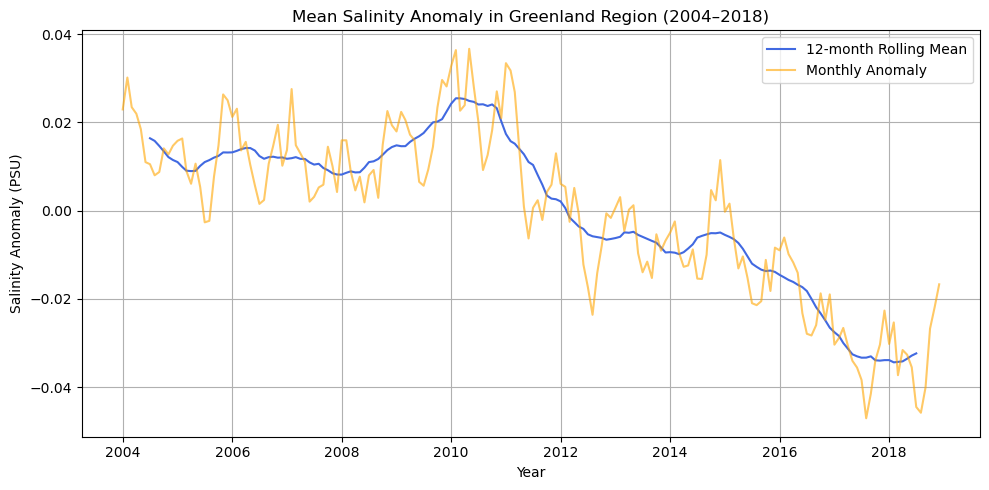

In [8]:
plt.figure(figsize=(10, 5))

# Plot the smoothed 12-month rolling average
plt.plot(
    greenland_smoothed.time, 
    greenland_smoothed, 
    color='royalblue', 
    label='12-month Rolling Mean'
)

# Plot the raw anomaly data
plt.plot(
    greenland_anom.time, 
    greenland_anom, 
    color='orange', 
    alpha=0.6, 
    label='Monthly Anomaly'
)

# Labels & titles
plt.title('Mean Salinity Anomaly in Greenland Region (2004–2018)')
plt.xlabel('Year')
plt.ylabel('Salinity Anomaly (PSU)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Fit linear trend
slope, intercept = np.polyfit(years[valid], values[valid], deg=1)
trend_per_decade = slope * 10
print(f"Greenland salinity trend: {trend_per_decade:.5f} PSU/decade")

Greenland salinity trend: -0.05388 PSU/decade


In [10]:
ds_surface = greenland_box.sel(pressure=0, method="nearest")

In [15]:
export_df = (
    greenland_smoothed
    .to_dataset(name="salinity_anomaly")  # Step 1: wrap it into a Dataset
    .to_dataframe()                       # Step 2: convert to DataFrame
    .dropna()                             # Step 3: drop any NaNs
    .reset_index()                        # Step 4: move `time` from index to a column
)

export_df.to_csv("greenland_smoothed_anomaly.csv", index=False)


In [14]:
print(export_df.head())

        time  salinity_anomaly
0 2004-07-01          0.016405
1 2004-08-01          0.015813
2 2004-09-01          0.014662
3 2004-10-01          0.013456
4 2004-11-01          0.012134
